In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'vgt' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 5 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'aapl':'12/12/1980' # Updated 1/2/21 1D, 5D ahead
               , 'acy': '01/18/1998' # Updated 1/2/21 1D, 5D ahead
               , 'amd': '03/17/1980' # Updated 1/2/21 1D, 5D ahead
               , 'baba': '09/15/2014' # Updated 1/2/21 1D, 5D ahead
               , 'bac': '02/19/1973' # Updated 1/2/21 1D, 5D ahead
               , 'crm': '06/23/2004' # Updated 1/2/21 1D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 1/2/21 1D, 5D ahead
               , 'goog': '08/16/2004' # Updated 1/2/21 1D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 1/2/21 1D, 5D ahead
               , 'idex': '05/23/2007' # Updated 1/2/21 1D, 5D ahead
               , 'intc': '03/16/1980' # Updated 1/2/21 1D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 1/2/21 1D, 5D ahead
               , 'ma': '05/21/2006' # Updated 1/2/21 1D, 5D ahead
               , 'msft': '03/10/1986' # Updated 1/2/21 1D, 5D ahead
               , 'nio': '09/10/2018' # Updated 1/2/21 1D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 1/2/21 1D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 1/2/21 1D, 5D ahead
               , 'tsla': '06/29/2010' # Updated 1/2/21 1D, 5D ahead
               , 'v': '03/16/2008' # Updated 1/2/21 1D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 1/2/21 1D, 5D ahead
               , 'vgt': '01/26/2004' # Updated 1/2/21 1D, 5D ahead
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-17,350.489990,348.329987,349.260010,350.000000,487300.0,350.000000,-0.002119,0.006201,0.009111,0.006732,0.007105,-1
2020-12-18,350.809998,347.450012,350.769989,349.059998,378000.0,349.059998,0.004875,0.009670,-0.002686,0.007039,0.006922,1
2020-12-21,350.160004,342.559998,345.769989,349.989990,603600.0,349.989990,-0.012205,0.022186,0.002664,0.007226,0.006597,-1
2020-12-22,355.070007,350.790009,352.160004,353.769989,525000.0,353.769989,-0.004572,0.012201,0.010800,0.005461,0.005433,-1
2020-12-23,354.859985,350.500000,354.470001,350.549988,388700.0,350.549988,0.011059,0.012439,-0.009102,0.008269,0.002158,1
2020-12-24,353.670013,351.269989,351.269989,352.880005,182400.0,352.880005,-0.004583,0.006832,0.006647,0.007812,0.001665,-1
2020-12-28,356.480011,353.480011,356.250000,355.359985,607600.0,355.359985,0.002498,0.008487,0.007028,0.007666,0.003607,-1
2020-12-29,357.690002,352.329987,357.239990,353.010010,532800.0,353.010010,0.011841,0.015213,-0.006613,0.008964,0.001752,-1
2020-12-30,355.079987,352.839996,354.549988,353.480011,354500.0,353.480011,0.003018,0.006348,0.001331,0.007447,-0.000142,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.69708219 0.69708219 0.69708219]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

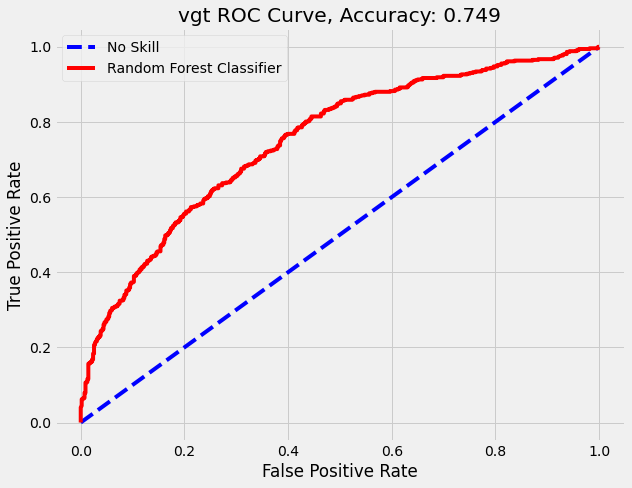

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

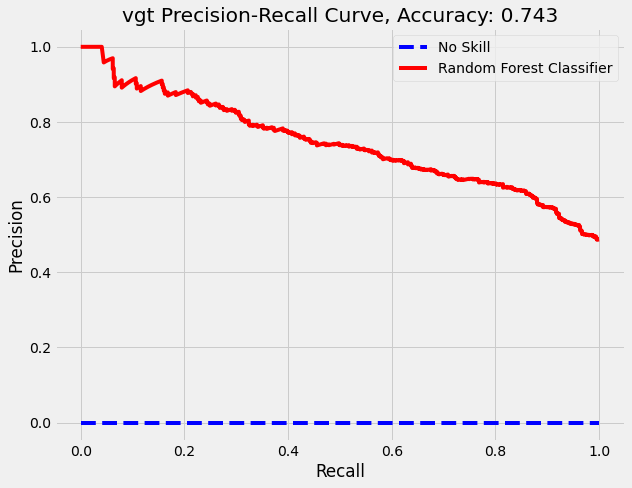

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

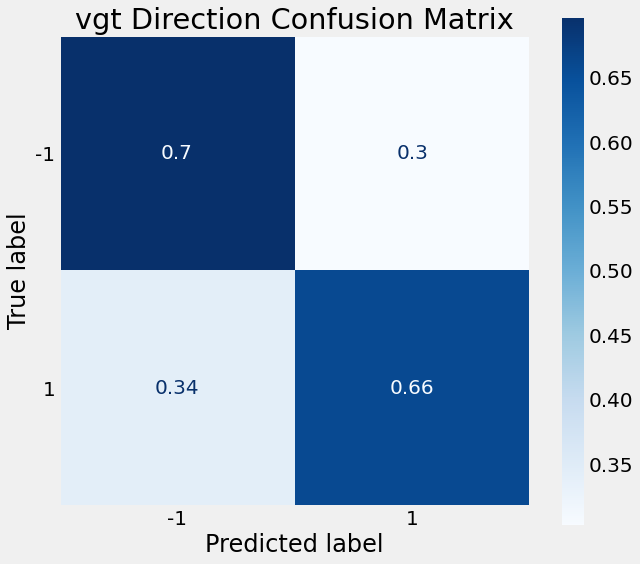

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6957285822258267'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High             354.390015
Low              351.100006
Open             353.700012
Close            353.790009
Volume        410300.000000
Adj Close        353.790009
oc                -0.000254
hl                 0.009371
adj                0.000877
5stdev_adj         0.005538
5sma_adj           0.001854
direction         -1.000000
Name: 2020-12-31 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.000254
hl            0.009371
5stdev_adj    0.005538
5sma_adj      0.001854
Name: 2020-12-31 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    4256.000000
mean        0.000603
std         0.013761
min        -0.134863
25%        -0.005372
50%         0.001191
75%         0.007163
max         0.110140
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Sell or hold vgt


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-24,353.670013,351.269989,351.269989,352.880005,182400.0,352.880005,-0.004583,0.006832,0.006647,0.007812,0.001665,-1,-1,-0.007028
2020-12-28,356.480011,353.480011,356.250000,355.359985,607600.0,355.359985,0.002498,0.008487,0.007028,0.007666,0.003607,-1,1,-0.006613
2020-12-29,357.690002,352.329987,357.239990,353.010010,532800.0,353.010010,0.011841,0.015213,-0.006613,0.008964,0.001752,-1,1,0.001331
2020-12-30,355.079987,352.839996,354.549988,353.480011,354500.0,353.480011,0.003018,0.006348,0.001331,0.007447,-0.000142,-1,1,0.000877
2020-12-31,354.390015,351.100006,353.700012,353.790009,410300.0,353.790009,-0.000254,0.009371,0.000877,0.005538,0.001854,-1,-1,-0.001191


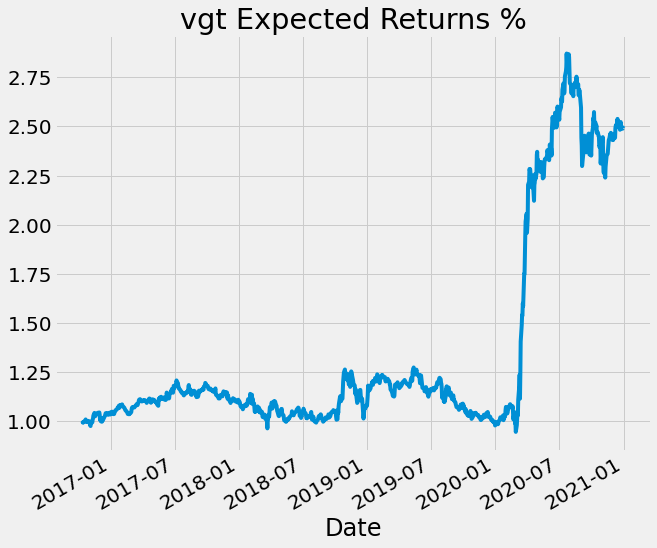

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

2.941566197266417

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

5.492750920298312

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/

## 